# Read data

In [28]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [19]:
# Paths to the data and correlation results
dirs = ["res6", "res8"]
names = ["MGS1_SD6", "MGS1_SD8"]
paths_data = [f"/mnt/c/Users/Elena/Desktop/Data_processing/020226_U2OS2_fixed_MGS1/{dir}/results.csv" for dir in dirs]
paths_corr = [f"/mnt/c/Users/Elena/Desktop/Data_processing/020226_U2OS2_fixed_MGS1/{dir}/spearman_pairs.csv" for dir in dirs]
# Load data and correlation results into dictionaries
dfs = {
    name: pd.read_csv(path)
    for name, path in zip(names, paths_data)
}
corrs = {
    name: pd.read_csv(path)
    for name, path in zip(names, paths_corr)
}

# Combine dataframes and add a 'Group' column
combined = []
for name, df in dfs.items():
    temp = df.copy()
    temp["Group"] = name
    combined.append(temp)
combined_df = pd.concat(combined, ignore_index=True)


# Graphs

## Boxplots

<Figure size 640x480 with 0 Axes>

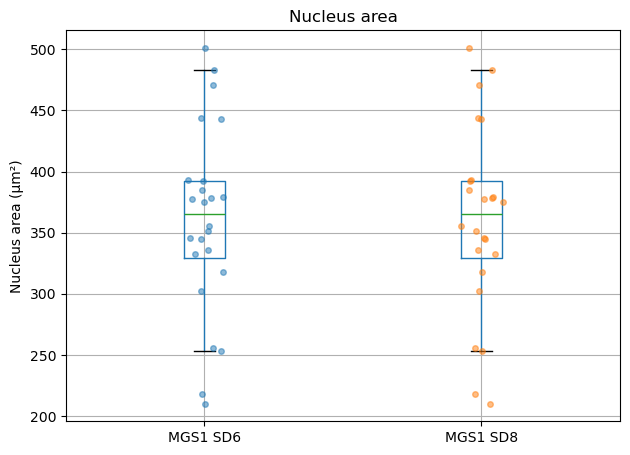

<Figure size 640x480 with 0 Axes>

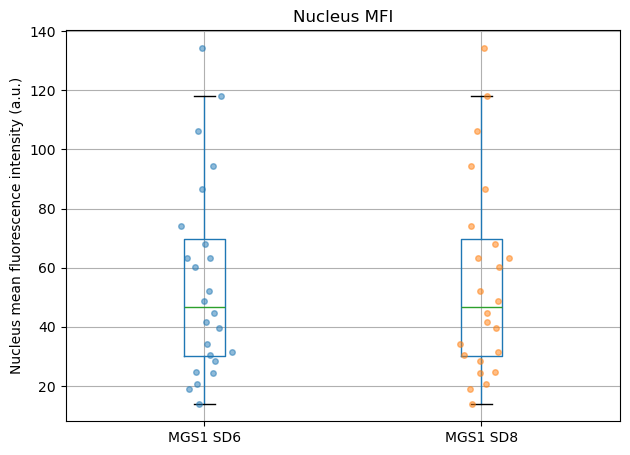

<Figure size 640x480 with 0 Axes>

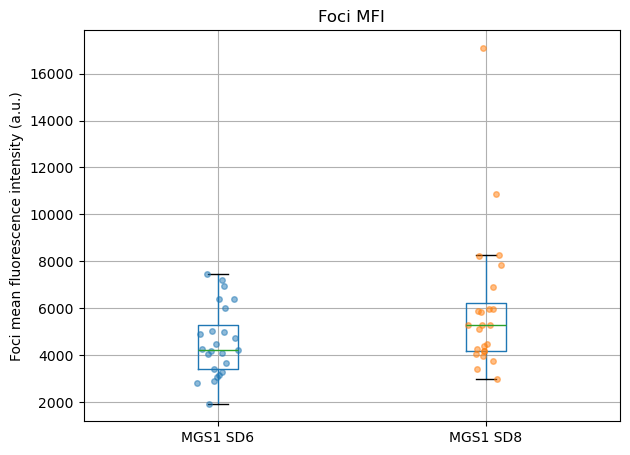

<Figure size 640x480 with 0 Axes>

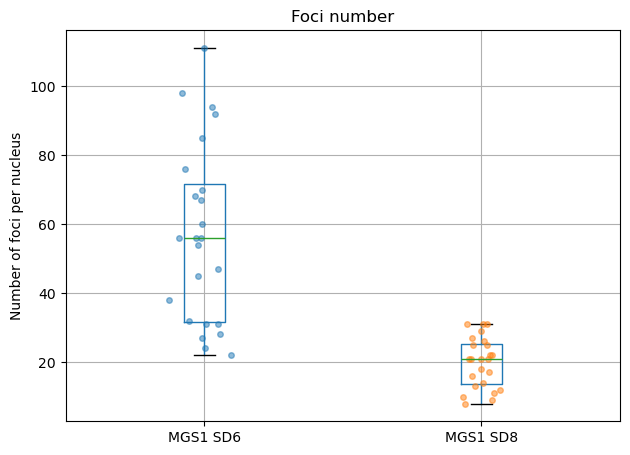

In [36]:
variables = ["Nucleus_area", "Nucleus_MFI", "Foci_MFI", "Foci_number"]

# Custom Y-axis labels
y_labels = {
    "Nucleus_area": "Nucleus area (µm²)",
    "Nucleus_MFI": "Nucleus mean fluorescence intensity (a.u.)",
    "Foci_MFI": "Foci mean fluorescence intensity (a.u.)",
    "Foci_number": "Number of foci per nucleus"
}

for var in variables:
    plt.figure()
    ax = combined_df.boxplot(column=var, by="Group", showfliers=False)

    for i, group in enumerate(dfs.keys(), start=1):
        y = combined_df[combined_df["Group"] == group][var].dropna()
        x = np.random.normal(i, 0.04, size=len(y))
        plt.plot(x, y, "o", alpha=0.5, markersize=4)

    # Replace underscores in x tick labels
    new_labels = [label.get_text().replace("_", " ") 
                  for label in ax.get_xticklabels()]
    ax.set_xticklabels(new_labels)

    plt.title(var.replace("_", " "))
    plt.ylabel(y_labels[var])
    plt.suptitle("")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()


## Boxplots with t-test

Foci_MFI: t = -2.06, p = 4.682e-02


<Figure size 640x480 with 0 Axes>

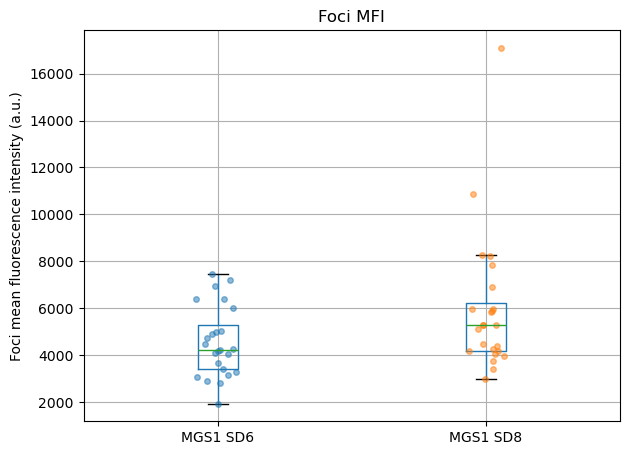

Foci_number: t = 6.74, p = 3.331e-07


<Figure size 640x480 with 0 Axes>

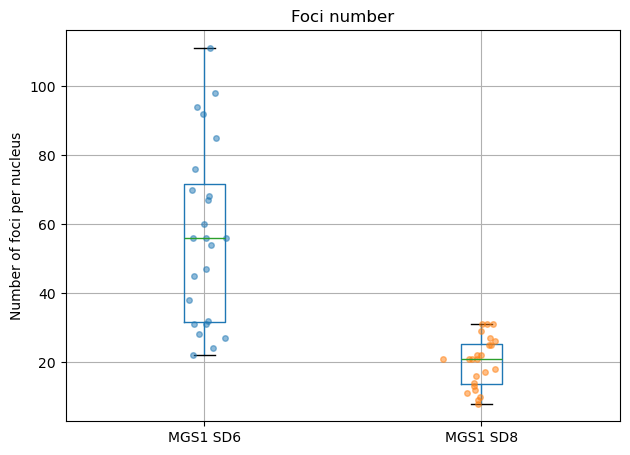

In [ ]:
variables = ["Foci_MFI", "Foci_number"]

groups = list(dfs.keys())
group1, group2 = groups[0], groups[1]

for var in variables:
    plt.figure()
    ax = combined_df.boxplot(column=var, by="Group", showfliers=False)

    # Extract data
    data1 = combined_df[combined_df["Group"] == group1][var].dropna()
    data2 = combined_df[combined_df["Group"] == group2][var].dropna()

    # --- t-test ---
    t_stat, p_value = ttest_ind(data1, data2, equal_var=False)  # Welch version (safer)
    print(f"{var}: t = {t_stat:.2f}, p = {p_value:.3e}")

    # --- Jitter ---
    for i, group in enumerate(groups, start=1):
        y = combined_df[combined_df["Group"] == group][var].dropna()
        x = np.random.normal(i, 0.04, size=len(y))
        ax.plot(x, y, "o", alpha=0.5, markersize=4)

    # Replace underscores in group labels
    new_labels = [label.get_text().replace("_", " ") 
                  for label in ax.get_xticklabels()]
    ax.set_xticklabels(new_labels)

    # Y-axis label
    ax.set_ylabel(y_labels[var])
    ax.set_title(var.replace("_", " "))
    plt.suptitle("")
    plt.xlabel("")

    plt.tight_layout()
    plt.show()


# Spearman correlation visualization

In [ ]:
col1 = "Foci_MFI"
col2 = "Foci_number"

plt.figure()
plt.scatter(data[col1], data[col2], alpha=0.6)
plt.xlabel(col1)
plt.ylabel(col2)
plt.tight_layout()
plt.show()